En esta parte construyo los datos sintéticos y los ploteo

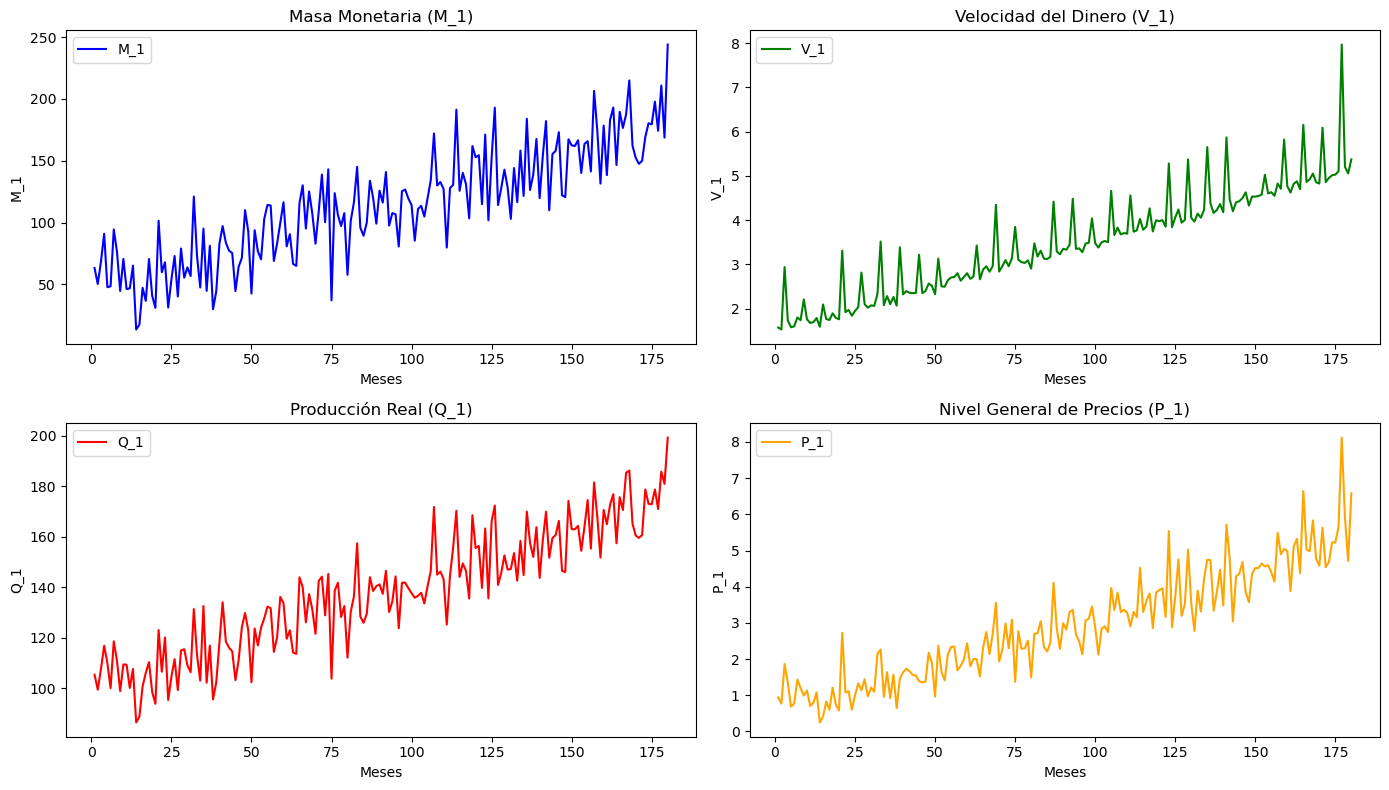

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import plot_tree, export_text

# Función para generar M_1 con pendiente lineal suave, ruido gausiano y aumento del 5% cada 3 meses
def generar_M_1(meses):
    np.random.seed(42)
    ruido = np.random.normal(0, 25, len(meses))
    pendiente_suave = 0.7 * meses # Pendiente menor a la de M_1
    M_1 = 50 + pendiente_suave + ruido
    for i in range(0, len(meses), 6):
        pico = 2 + np.random.normal(0, 0.5) # Pico gausiano que duplica la velocidad
        M_1[i+1] += pico # Duración del pico: 1 meses
    return M_1


#Función para generar V_1 con pendiente lineal suave, picos gaussianos cada 6 meses y ruido
def generar_V_1(meses):
    np.random.seed(42)
    pendiente_suave = 0.02 * meses # Pendiente menor a la de M_1
    V_1 = 1.5 + pendiente_suave + np.random.normal(0, 0.1, len(meses))
    for i in range(0, len(meses), 6):
        pico = 1 + np.random.normal(0, 0.5) # Pico gausiano que triplica la velocidad
        V_1[i+2] += pico # Duración del pico: 2 meses
    return V_1


#Función para generar Q_1 con pendiente lineal suave, picos gaussianos cada 6 meses (2 meses después de los picos de V_1) y ruido
def generar_Q_1(meses):
    np.random.seed(42)
    pendiente_suave = 0.4 * meses # Pendiente levemente distinta a la de V_1
    Q_1 = 100 + pendiente_suave + np.random.normal(0, 10, len(meses))
    for i in range(2, len(meses), 6):
        pico = 10 + np.random.normal(0, 0.5) # Pico gausiano que duplica la producción base
        Q_1[i+2] += pico # Duración del pico: 2 meses
    return Q_1

# Generar datos
meses = np.arange(1, 181)
M_1 = generar_M_1(meses)
V_1 = generar_V_1(meses)
Q_1 = generar_Q_1(meses)

# Crear DataFrame
df = pd.DataFrame({
    'Meses': meses,
    'M_1': M_1,
    'V_1': V_1,
    'Q_1': Q_1
})

# Calcular P_1 sin desfase
df['P_1'] = (df['M_1'] * df['V_1']) / df['Q_1']

# Colores para los gráficos
colors = ['blue', 'green', 'red', 'orange']

# Plotear los resultados
plt.figure(figsize=(14, 8))

plt.subplot(2, 2, 1)
plt.plot(df['Meses'], df['M_1'], color=colors[0], label='M_1')
plt.title('Masa Monetaria (M_1)')
plt.xlabel('Meses')
plt.ylabel('M_1')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(df['Meses'], df['V_1'], color=colors[1], label='V_1')
plt.title('Velocidad del Dinero (V_1)')
plt.xlabel('Meses')
plt.ylabel('V_1')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(df['Meses'], df['Q_1'], color=colors[2], label='Q_1')
plt.title('Producción Real (Q_1)')
plt.xlabel('Meses')
plt.ylabel('Q_1')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(df['Meses'], df['P_1'], color=colors[3], label='P_1')
plt.title('Nivel General de Precios (P_1)')
plt.xlabel('Meses')
plt.ylabel('P_1')
plt.legend()

plt.tight_layout()
plt.show()

In [2]:
df
#df['P_1'] = (df['M_1'] * df['V_1']) / df['Q_1']

,Meses,M_1,V_1,Q_1,P_1
0,1,63.117854,1.569671,105.367142,0.940277
1,2,50.256226,1.526174,99.417357,0.771492
2,3,68.292213,2.937603,107.676885,1.863124
3,4,90.875746,1.732303,116.830299,1.347461
4,5,47.646166,1.576585,109.971300,0.683071
...,...,...,...,...,...
175,176,197.805947,5.102718,178.671832,5.649173
176,177,174.225047,7.967666,170.930019,8.121259
177,178,210.938352,5.205353,185.735341,5.911684
178,179,168.683579,5.053534,180.879797,4.712789


Hasta aquí no están introducidos ni los desfasajes ni están construidos el resto de los features

In [5]:

# Función para crear y desfasear el DataFrame
def crear_y_desfasear_dataframe(meses, V, M, Q, P):
    data = {
        'Meses': meses,
        'Velocidad del Dinero (V)': V,
        'Masa Monetaria (M)': M,
        'Producción Real (Q)': Q,
        'Nivel de Precios (P)': P,

    }
    df = pd.DataFrame(data)
    df['Velocidad del Dinero (V)'] = df['Velocidad del Dinero (V)'].shift(-3)
    df['Producción Real (Q)'] = df['Producción Real (Q)'].shift(0)
    df['Masa Monetaria (M)'] = df['Masa Monetaria (M)'].shift(-1)
    return df

# Crear el DataFrame con los datos desfasados
df = crear_y_desfasear_dataframe(meses, V_1, M_1, Q_1, df['P_1'])

# Eliminar filas con valores NaN resultantes del desfase
df = df.dropna().reset_index(drop=True)

# Crear características desfasadas (lags) hasta un máximo de 7 meses
for lag in range(0, 8):
    df[f'V_lag_{lag}'] = df['Velocidad del Dinero (V)'].shift(lag)
    df[f'M_lag_{lag}'] = df['Masa Monetaria (M)'].shift(lag)
    df[f'Q_lag_{lag}'] = df['Producción Real (Q)'].shift(lag)

# Eliminar filas con valores NaN nuevamente debido a la creación de lags
df = df.dropna().reset_index(drop=True)

Aquí observamos la construcción del dataframe con múltiples features tal como explico en el archivo. 
He eliminado las filas con datos vacíos.

In [6]:
df

,Meses,Velocidad del Dinero (V),Masa Monetaria (M),Producción Real (Q),Nivel de Precios (P),V_lag_0,M_lag_0,Q_lag_0,V_lag_1,M_lag_1,...,Q_lag_4,V_lag_5,M_lag_5,Q_lag_5,V_lag_6,M_lag_6,Q_lag_6,V_lag_7,M_lag_7,Q_lag_7
0,8,1.673658,44.563140,110.874347,1.196066,1.673658,44.563140,110.874347,1.754256,76.357289,...,116.830299,1.596586,90.875746,107.676885,1.576585,68.292213,99.417357,1.732303,50.256226,105.367142
1,9,1.693427,70.564001,98.905256,0.993256,1.693427,70.564001,98.905256,1.673658,44.563140,...,109.971300,1.797921,47.646166,116.830299,1.596586,90.875746,107.676885,1.576585,68.292213,99.417357
2,10,1.784196,46.114558,109.425600,1.131246,1.784196,46.114558,109.425600,1.693427,70.564001,...,100.058630,1.736743,48.346576,109.971300,1.797921,47.646166,116.830299,1.596586,90.875746,107.676885
3,11,1.588672,46.756756,109.337244,0.705889,1.588672,46.756756,109.337244,1.784196,46.114558,...,118.592128,2.204474,94.380320,100.058630,1.736743,48.346576,109.971300,1.797921,47.646166,116.830299
4,12,2.092062,65.149057,100.142702,0.790663,2.092062,65.149057,100.142702,1.588672,46.756756,...,110.874347,1.754256,76.357289,118.592128,2.204474,94.380320,100.058630,1.736743,48.346576,109.971300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,173,5.102718,180.328799,178.686507,4.688608,5.102718,180.328799,178.686507,5.027669,169.172457,...,165.146119,6.088572,162.165297,186.167930,4.824626,215.019825,185.277495,4.855461,187.451504,170.527809
166,174,7.967666,179.417270,173.011520,5.226180,7.967666,179.417270,173.011520,5.102718,180.328799,...,160.462638,4.858419,152.414120,165.146119,6.088572,162.165297,186.167930,4.824626,215.019825,185.277495
167,175,5.205353,197.805947,172.766908,5.221200,5.205353,197.805947,172.766908,7.967666,179.417270,...,159.504856,4.952290,147.462139,160.462638,4.858419,152.414120,165.146119,6.088572,162.165297,186.167930
168,176,5.053534,174.225047,178.671832,5.649173,5.053534,174.225047,178.671832,5.205353,197.805947,...,160.641897,5.014115,150.004743,159.504856,4.952290,147.462139,160.462638,4.858419,152.414120,165.146119


    Feature  Importance
3   V_lag_3    0.644863
6   Q_lag_0    0.183873
13  M_lag_1    0.133289
0   V_lag_0    0.021052
8   Q_lag_2    0.011490
15  M_lag_3    0.005433
11  Q_lag_5    0.000000
16  M_lag_4    0.000000
14  M_lag_2    0.000000
12  M_lag_0    0.000000
9   Q_lag_3    0.000000
10  Q_lag_4    0.000000
1   V_lag_1    0.000000
7   Q_lag_1    0.000000
5   V_lag_5    0.000000
4   V_lag_4    0.000000
2   V_lag_2    0.000000
17  M_lag_5    0.000000


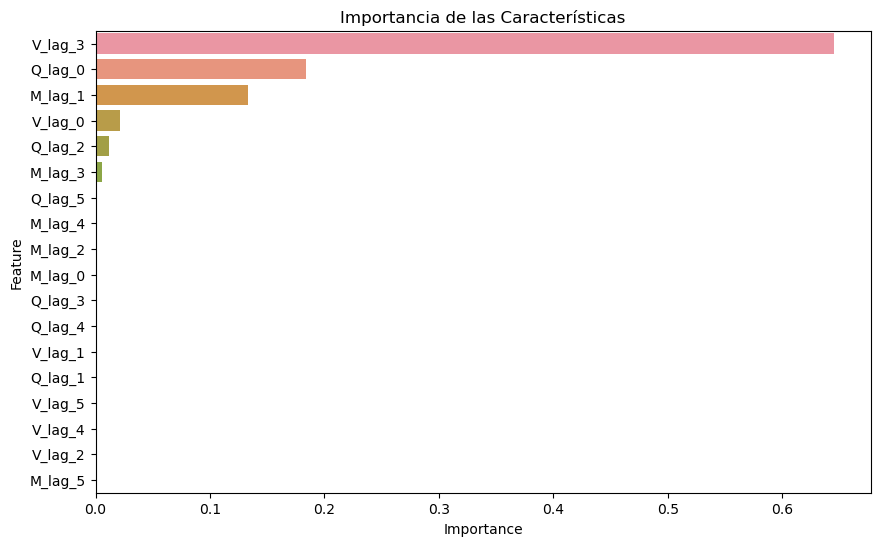

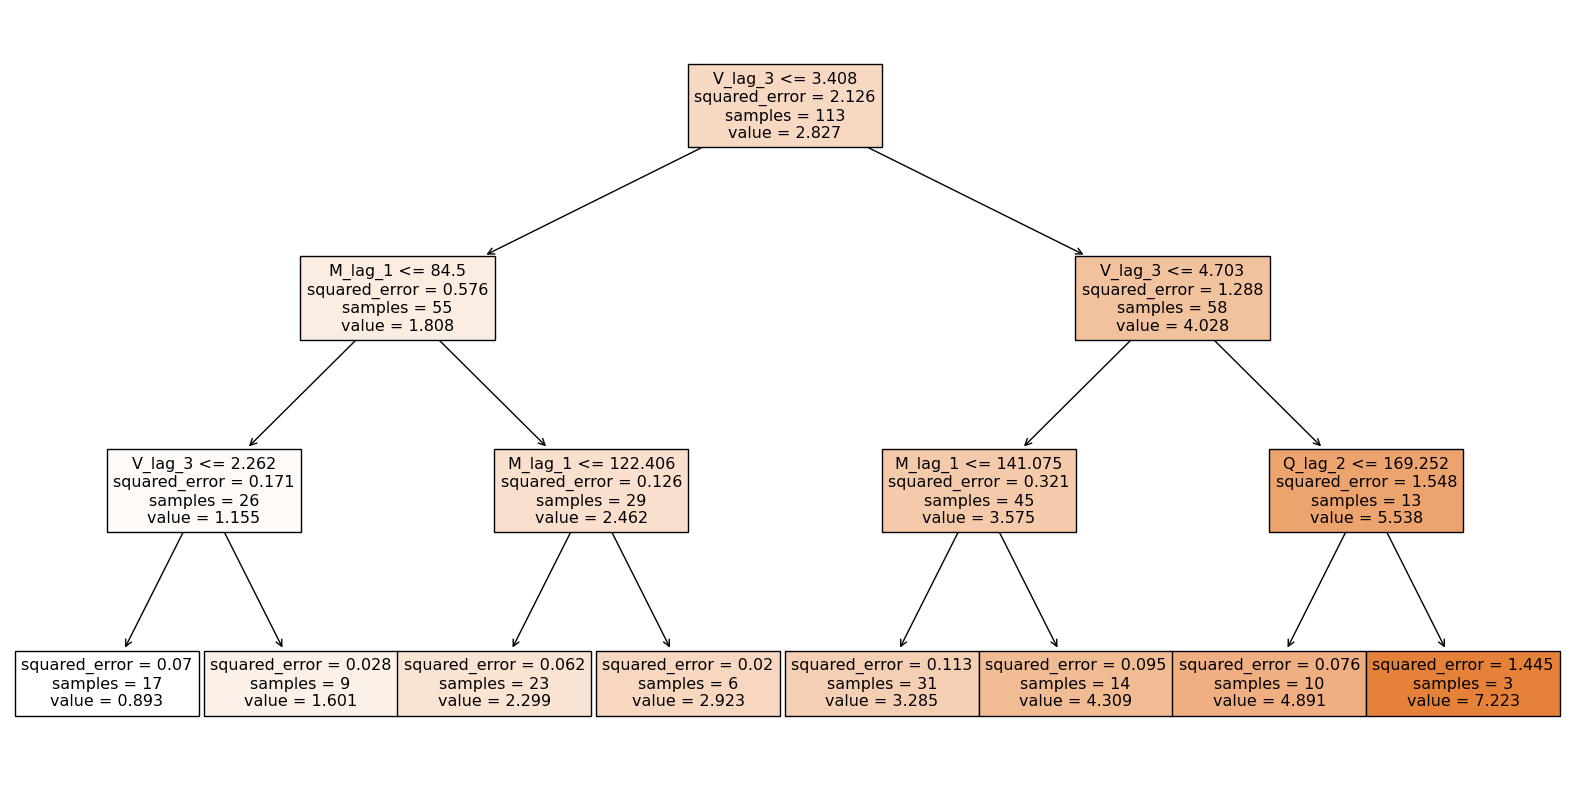

|--- V_lag_3 <= 3.41
|   |--- M_lag_1 <= 84.50
|   |   |--- V_lag_3 <= 2.26
|   |   |   |--- value: [0.89]
|   |   |--- V_lag_3 >  2.26
|   |   |   |--- value: [1.60]
|   |--- M_lag_1 >  84.50
|   |   |--- M_lag_1 <= 122.41
|   |   |   |--- value: [2.30]
|   |   |--- M_lag_1 >  122.41
|   |   |   |--- value: [2.92]
|--- V_lag_3 >  3.41
|   |--- V_lag_3 <= 4.70
|   |   |--- M_lag_1 <= 141.07
|   |   |   |--- value: [3.28]
|   |   |--- M_lag_1 >  141.07
|   |   |   |--- value: [4.31]
|   |--- V_lag_3 >  4.70
|   |   |--- Q_lag_2 <= 169.25
|   |   |   |--- value: [4.89]
|   |   |--- Q_lag_2 >  169.25
|   |   |   |--- value: [7.22]



In [9]:

# Definir características (lags) y variable objetivo
features = [f'V_lag_{i}' for i in range(0, 6)] + [f'Q_lag_{i}' for i in range(0, 6)] + [f'M_lag_{i}' for i in range(0, 6)]
target = 'Nivel de Precios (P)'


# Entrenar un modelo de Random Forest con hiperparámetros ajustados
X = df[features]
y = df[target]

model = RandomForestRegressor(
    n_estimators=5,
    max_depth=3,
    min_samples_split=10,
    min_samples_leaf=3,
    random_state=42
)
model.fit(X, y)

# Obtener la importancia de las características
feature_importances = model.feature_importances_
feature_importances_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Imprimir la importancia de las características
print(feature_importances_df)

# Visualizar la importancia de las características
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importances_df, x='Importance', y='Feature')
plt.title('Importancia de las Características')
plt.show()

# Imprimir un árbol de decisión del bosque aleatorio
# Seleccionamos el primer árbol
tree = model.estimators_[0]
plt.figure(figsize=(20, 10))
plot_tree(tree, feature_names=features, filled=True)
plt.show()

# Exportar texto del árbol de decisión para ver las reglas
tree_text = export_text(tree, feature_names=features)
print(tree_text)